# **INDAH SRI LESTARI  - 1207050048**

#<b>PENERAPAN ALGORITMA LSTM UNTUK CHATBOT UKK PRAMUKA<b>

<b>Chatbot</b> merupakan bagian dari Natural Language Processing yang digunakan untuk percakapan dengan pengguna melalui teks dan ucapan.

Dalam tahapan Chatbot ini ada tahapan yang harus diperhatikan yaitu,

1. Import Library
2. Load Dataset
3. Preprocessing Data
4. Input Length, Output Length and Vocabulary
5. Long Short Term Memory Model
6. Evaluation Model Analysis
7. Testing Chatbot
8. Save The Model


# **Load Google Drive**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Setelah dirunning maka ada notifikasi untuk **Permit this notebook to your access Google Drive** lalu pilih izinkan dan akan diproses ke dalam login akun google

## **Instalasi Library Pengenal Suara**

Pada proyek AI Chatbot membutuhkan beberapa package library yaitu **Speech Recognition** dan **Google Text To Speech** yang harus di install.

In [ ]:
!pip -q install speechrecognition

In [ ]:
!pip -q install gtts

**Notes : Penginstalan dengan tanda -q maksudnya adalah mode quiet atau diam sehingga tidak mengeluarkan output saat eksekusi**

# **Import Library**

Tahapan pertama sebelum melakukan eksplorasi dan praproses pada data adalah memasukan library yang akan digunakan untuk menganalisa dataset dengan menggunakan metode Deep Learning seperti Neural Network dalam pengolahan teks, Chatbot dll. Library yang saya gunakan yaitu NumPy untuk komputasi matematika, Matplotlib untuk visualisasi model data, Natural Language Toolkit atau NLTK untuk pengolahan teks, Pandas untuk membaca data, serta Tensorflow untuk model pada data menggunakan algoritma LSTM (Long Short Term Memory).

In [ ]:
# Import Libraries
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from gtts import gTTS
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import speech_recognition as sr
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

## **Download NLTK Package**

In [ ]:
# Package sentence tokenizer
nltk.download('punkt')
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# **Load Dataset Json**

Setelah import library, tahapan selanjutnya adalah me-load dataset yang telah disediakan. Dataset yang digunakan berformat **.json** yang didapat melalui wawancara kepada pengurus UKK Pramuka UIN SGD.

Data Json merupakan data yang termasuk dalam *semi structured* yang dimana data ini menampung beberapa bagian data seperti **tag**, **pattern**, **context**, dan **response**.

In [ ]:
# Importing the dataset
with open('/content/drive/MyDrive/SEMESTER 7/DEEP LEARNING/intents.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter
# Tambahkan data intents dalam json
for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    # digunakan untuk pattern atau teks pertanyaan dalam json
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # tambahkan ke dalam list kelas dalam data
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [ ]:
# Cetak data keseluruhan
data

,patterns,tags
0,Assalamualaikum wr wb,salam
1,Assalamualaikum,salam
2,assalamualaikum wr wb,salam
3,samlekom,salam
4,P,greeting
...,...,...
77,apa itu peka,peka
78,peka itu apa,peka
79,apa yang dimaksud peka,peka
80,periode menjadi anggota pramuka,periode


In [ ]:
# Cetak data baris pertama sampai baris kelima
data.head()

,patterns,tags
0,Assalamualaikum wr wb,salam
1,Assalamualaikum,salam
2,assalamualaikum wr wb,salam
3,samlekom,salam
4,P,greeting


In [ ]:
# Cetak data baris ke-70 sampai baris akhir
data.tail()

,patterns,tags
77,apa itu peka,peka
78,peka itu apa,peka
79,apa yang dimaksud peka,peka
80,periode menjadi anggota pramuka,periode
81,semester berapa untuk menjadi anggota pramuka,periode


Data yang telah kita miliki dalam format JSON yang dapat digunakan melalui pandas dengan cara konversi. Data JSON yang saya miliki didapat dengan cara manual melalui wawancara kepada pengurus UKK Pramuka UIN SGD

# **Preprocessing The Data**

Setelah kita meload data dan mengonversi data json menjadi dataframe. Tahapan selanjutnya adalah praproses pada dataset yang kita gunakan saat ini yaitu dengan cara:

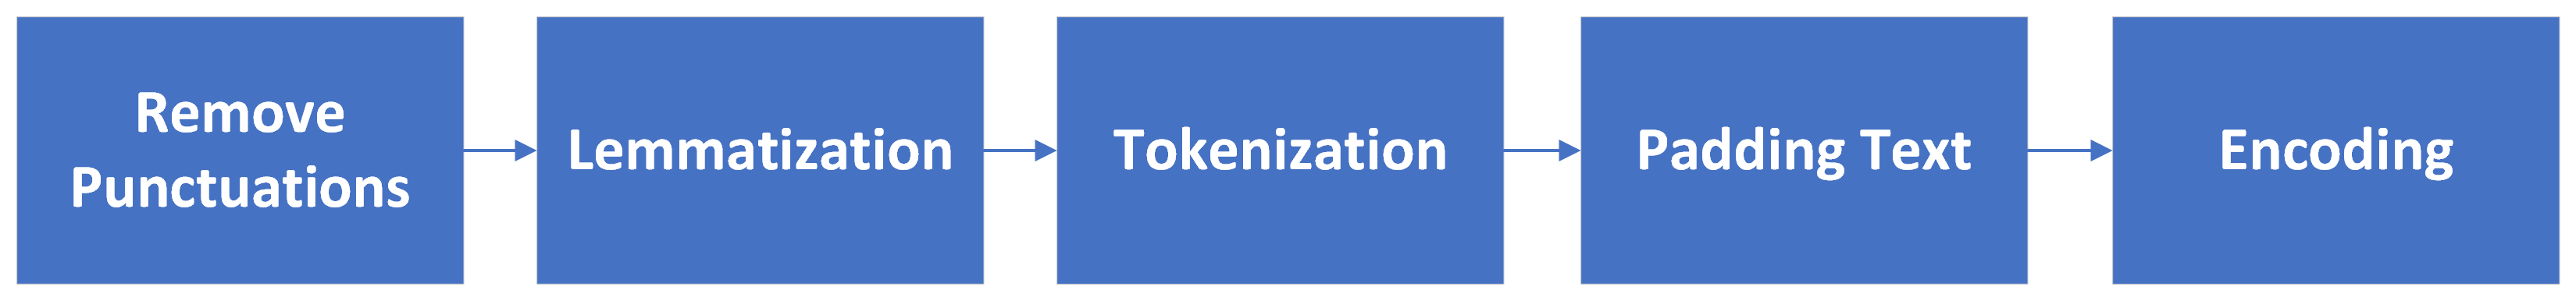

1.   Remove Punctuations (Menghapus Punktuasi)
2.   Lematization (Lematisasi)
3.   Tokenization (Tokenisasi)
4.   Apply Padding (Padding)
5.   Encoding the Outputs (Konversi Keluaran Enkoding)

Kelima tahapan pemrosesan teks ini dijelaskan pada bagian langkah selanjutnya.

## **Remove Punctuations**

Tahapan praproses pada data teks yang pertama adalah menghapus punktuasi atau tanda baca seperti *special character* yaitu **'!'** (**tanda seru**) **','** (**tanda koma**) **'.'** (**tanda titik sebagai berhenti**) '**?**' (**tanda tanya**) dan tanda baca yang lain. Tahapan ini gunanya untuk mempermudah pemrosesan data teks yang akan kita olah.

In [ ]:
# Removing Punctuations (Menghilangkan Punktuasi)
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))

## **Lemmatization (Lematisasi)**

Lematisasi atau *Lemmatization* adalah proses dimana merujuk pada melakukan sesuatu menggunakan vocabulary atau kosakata dan analisis morfologi kata-kata untuk menghilangkan *inflectional endings only* dan untuk mengembalikan bentuk *dictionary* (kata dalam kamus) dari sebuah kata yang dikenal sebagai ***lemma***.

Contoh Lematisasi : **Menggunakan** (Kata Imbuhan) -> **Guna** (Kata Dasar)

Dalam contoh berikut proses lematisasi awalnya data teks menggunakan kata imbuhan yaitu **Menggunakan** dimana **meng-** + **guna** (kata dasar yang berawalan vokal g) + **kan** (sebagai akhiran) diubah menjadi kata dasar yaitu '**Guna**'.

Proses ini dimana menghilangkan Prefiks pada imbuhan (**Meng-**) dan Suffiks pada (**-kan**).

In [ ]:
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lemmatized words", words)

112 unique lemmatized words ['ada', 'afternoon', 'aja', 'anggota', 'apa', 'apakah', 'assalamualaikum', 'bagaimana', 'bai', 'bandung', 'banyak', 'berapa', 'berdirinya', 'biaya', 'biayanya', 'bisa', 'bro', 'bye', 'byee', 'cara', 'dadah', 'dah', 'di', 'didirikan', 'dikeluarkan', 'dimaksud', 'estimasi', 'gimana', 'good', 'hai', 'hallo', 'halo', 'hei', 'hi', 'hoo', 'hy', 'ingin', 'itu', 'jadi', 'jalan', 'jalur', 'jumpa', 'kabar', 'kabarmu', 'kabarnya', 'kapan', 'kasar', 'kasih', 'kawan', 'kegiatan', 'kegiatannya', 'keluar', 'kerjanya', 'lewat', 'maaf', 'makasih', 'malam', 'mendaftar', 'menjadi', 'morning', 'mu', 'nuhun', 'ok', 'okay', 'okayy', 'okee', 'okeey', 'okey', 'p', 'pagi', 'peka', 'pendaftaran', 'periode', 'perlu', 'persyaratan', 'pertengahan', 'pramuka', 'program', 'proker', 'prokernya', 'prosedur', 'saja', 'samlekom', 'sampai', 'saya', 'scoutbot', 'sebagai', 'see', 'sejarah', 'sejarahnya', 'selamat', 'semester', 'si', 'siang', 'sore', 'syarat', 'syaratnya', 'terima', 'terimakasih'

### **Menyortir Data Kelas Tags**

In [ ]:
# sorting pada data class
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

17 classes ['biaya', 'goodbye', 'greeting', 'jalur', 'kegiatan', 'keluar', 'minta_maaf', 'nanyain_kabar', 'ok_answer', 'peka', 'periode', 'proker', 'salam', 'sejarah', 'syarat_anggota', 'terima_kasih', 'unit']


### **Mencari Jumlah Keseluruhan Data Teks**

In [ ]:
# documents = kombinasi antara data pattern dengan data tag dalam intents json
print (len(documents), "documents")

606 documents


## **Tokenization (Tokenisasi)**

Setelah proses lematisasi dan mencari tahu data classes dan jumlah keseluruhan data patterns dengan intents-nya. Maka, tahapan selanjutnya proses tokenisasi. **Apa itu Tokenisasi?**

Tokenisasi adalah suatu proses memberikan urutan karakter dan sebuah unit dokumen terdefinisi. Tokenisasi juga merupakan tugas untuk memecah kalimat menjadi bagian-bagian yang disebut dengan '**Token**' dan menghilangkan bagian tertentu seperti tanda baca.

Contohnya: **Akun email saya di reset** ->  'Akun' 'email' ‘saya’ 'di' 'reset'

In [ ]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
train

[[10, 19, 20],
 [10],
 [10, 19, 20],
 [38],
 [39],
 [40],
 [41],
 [42],
 [43],
 [44],
 [45],
 [46],
 [47],
 [48],
 [49],
 [50],
 [51],
 [52],
 [53],
 [54],
 [55],
 [56],
 [57],
 [58],
 [59],
 [60],
 [61, 62],
 [11, 63],
 [4, 64, 65],
 [4, 66, 67],
 [12, 68],
 [12],
 [12, 69, 70],
 [71],
 [72],
 [21],
 [73],
 [74, 21],
 [75, 76],
 [77, 78],
 [79],
 [80, 22],
 [81],
 [82],
 [83, 22],
 [23, 24],
 [84],
 [23, 24, 85],
 [86],
 [11, 87],
 [11, 13, 2, 9, 25],
 [4, 13, 2, 9, 25],
 [2, 9, 88, 26],
 [26, 89, 2, 9],
 [13, 2],
 [5, 27, 1, 14],
 [27, 28, 15, 90, 1],
 [91, 92, 29, 93, 3, 2],
 [4, 94, 29, 6, 2],
 [95, 28, 3, 2],
 [4, 30, 6, 3, 2],
 [30, 96, 3, 1, 7],
 [1, 97, 31, 6, 3],
 [98, 1, 14],
 [5, 99, 1, 7],
 [100, 1, 7],
 [101, 102, 1, 103],
 [104, 5, 1, 7],
 [1, 14, 105, 16, 2],
 [5, 8, 17],
 [17, 1, 7],
 [5, 17, 1],
 [106, 15, 32, 16, 33, 107],
 [1, 15, 32, 16, 33, 34],
 [8, 35, 36, 108, 109],
 [8, 110, 35],
 [111, 8],
 [1, 37, 18],
 [18, 37, 1],
 [1, 36, 112, 18],
 [34, 6, 3, 2],
 [113, 8

## **Padding**

Setelah memproses tokenisasi yang dimana memecah kalimat menajdi bagian-bagian yang disebut token yang digunakan untuk mengolah data teks pada AI Chatbot maka tahapan selanjutnya adalah Padding.

**Apa itu Padding?**

**Padding** adalah Suatu proses untuk mengubah setiap sequence agar memiliki panjang yang sama. Pada padding, setiap sequence dibuat sama panjang dengan menambahkan nilai 0 secara suffiks atau prefiks hingga mencapai panjang maksimum sequence. Selain itu padding juga dapat memotong sequence hingga panjangnya sesuai dengan panjang maksimum sequence.

Padding juga adalah proses untuk membuat setiap kalimat pada teks memiliki panjang yang seragam. Sama seperti melakukan resize gambar, agar resolusi setiap gambar sama besar. Untuk menggunakan padding bisa impor library **pad_sequence**. Kemudian buat panggil fungsi pad_sequence() dan masukkan sequence hasil tokenisasi sebagai parameternya.

Contohnya: `sequences_samapanjang = pad_sequences(sequences)`

Yang nantinya akan dikeluarkan menjadi angka dengan awalan 0 seperti gambar dibawah ini.

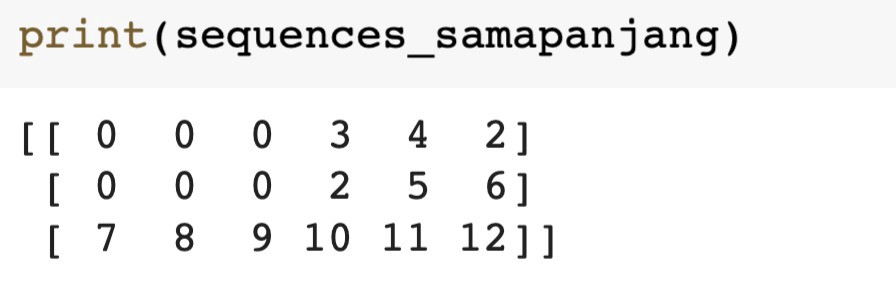

In [ ]:
# Melakukan proses padding pada data
x_train = pad_sequences(train)
# Menampilkan hasil padding
print(x_train)

[[  0   0   0  10  19  20]
 [  0   0   0   0   0  10]
 [  0   0   0  10  19  20]
 [  0   0   0   0   0  38]
 [  0   0   0   0   0  39]
 [  0   0   0   0   0  40]
 [  0   0   0   0   0  41]
 [  0   0   0   0   0  42]
 [  0   0   0   0   0  43]
 [  0   0   0   0   0  44]
 [  0   0   0   0   0  45]
 [  0   0   0   0   0  46]
 [  0   0   0   0   0  47]
 [  0   0   0   0   0  48]
 [  0   0   0   0   0  49]
 [  0   0   0   0   0  50]
 [  0   0   0   0   0  51]
 [  0   0   0   0   0  52]
 [  0   0   0   0   0  53]
 [  0   0   0   0   0  54]
 [  0   0   0   0   0  55]
 [  0   0   0   0   0  56]
 [  0   0   0   0   0  57]
 [  0   0   0   0   0  58]
 [  0   0   0   0   0  59]
 [  0   0   0   0   0  60]
 [  0   0   0   0  61  62]
 [  0   0   0   0  11  63]
 [  0   0   0   4  64  65]
 [  0   0   0   4  66  67]
 [  0   0   0   0  12  68]
 [  0   0   0   0   0  12]
 [  0   0   0  12  69  70]
 [  0   0   0   0   0  71]
 [  0   0   0   0   0  72]
 [  0   0   0   0   0  21]
 [  0   0   0   0   0  73]
 

Hasil setelah padding adalah setiap sequence memiliki panjang yang sama. Padding dapat melakukan ini dengan menambahkan 0 secara default pada awal sequence yang lebih pendek.

## **Encoding Text**

Setelah tahapan proses Padding pada suatu teks maka proses terakhir dalam pemrosesan teks adalah tahapan Encoding.

**Apa itu Encoding?**

**Encoding** merupakan suatu konversi atau pengkodean yang dimana data kategorik seperti huruf atau data teks menjadi data numerik atau angka menyesuaikan dengan data label yang digunakan. Pada proses tahapan ini, encoding mengubah data teks pada kolom data tags menjadi data numerik dengan bahasa biner komputer yaitu 0 dan 1.

Tujuan dari encoding ini adalah mempermudah saat proses komputasi data teks dan modelling.

In [ ]:
# Melakukan konversi data label tags dengan encoding
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])
print(y_train)

[12 12 12 12  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  8  8  8  8
  8  8  8  7  7  7  6  6  6  1  1  1  1  1  1  1  1  1 15 15 15 15 15 15
 15 13 13 13 13 13 13  3  3 14 14 14 14 14 14 14 11 11 11  4  4 16 16 16
  5  5  0  0  0  9  9  9 10 10]


Tokenizer pada Tensorflow memberikan token unik untuk setiap kata yang berbeda. Dan juga padding dilakukan untuk mendapatkan semua data dengan panjang yang sama sehingga dapat mengirimkannya ke lapisan atau layer model LSTM. variabel target juga dikodekan menjadi nilai desimal.

# **Input Length, Output Length and Vocabulary**

In [ ]:
# Melihat hasil input pada data teks
input_shape = x_train.shape[1]
print(input_shape)

6


In [ ]:
# Melakukan definisi tiap kalimat dan kata pada data teks
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

# Melakukan pemeriksaan pada data output label teks
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  113
output length:  17


**Input length** dan **output length** terlihat sangat jelas hasilnya. Mereka adalah untuk bentuk input dan bentuk output dari data train atau latih yang akan diproses pada algoritma LSTM yang akan dilatih.

**Vocabulary Size** adalah untuk lapisan penyematan untuk membuat representasi vektor unik untuk setiap kata.

## **Save Model Words & Classes**

Setelah dilakukan pemrosesan teks yang dilakukan lima tahap maka kita bisa simpan model pemrosesan teks tersebut dengan menggunakan format pickle.

Hal ini biasanya digunakan untuk membuat hubungan model yang telah dilatih dengan model pemrosesan teks.

In [ ]:
# Simpan hasil pemrosesan teks dengan menggunakan pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))

## **Save Label Encoder & Tokenizer**

In [ ]:
pickle.dump(le, open('le.pkl','wb'))
pickle.dump(tokenizer, open('tokenizers.pkl','wb'))

# **Long Short Term Memory (LSTM) Model**

Setelah menyimpan model untuk hasil pemrosesan teks, tahapan selanjutnya adalah melakukan modelling atau pemodelan untuk Chatbot dengan menggunakan algoritma LSTM (Long Short Term Memory).

**Apa itu Algoritma LSTM?**

**LSTM (Long Short Term Memory)** merupakan algoritma Deep Learning yang populer dan cocok digunakan untuk membuat prediksi dan klasifikasi yang berhubungan dengan waktu dan data teks.

Algoritma ini bisa dikatakan pengembangan atau salah satu jenis dari algoritma RNN (Recurrent Neural Network). Dalam algoritma RNN, output dari langkah terakhir diumpankan kembali sebagai input pada langkah yang sedang aktif. Namun, algoritma RNN memiliki kekurangan yaitu tidak dapat memprediksi kata yang disimpan dalam memori jangka panjang.

Struktur algoritma LSTM terdiri atas neural network dan beberapa blok memori yang berbeda. Blok memori ini disebut sebagai cell.  State dari cell dan hidden state akan diteruskan ke cell berikutnya.

Seperti yang ditunjukkan pada gambar di bawah, bangun berbentuk persegi panjang berwarna biru adalah **ilustrasi cell** pada LSTM.

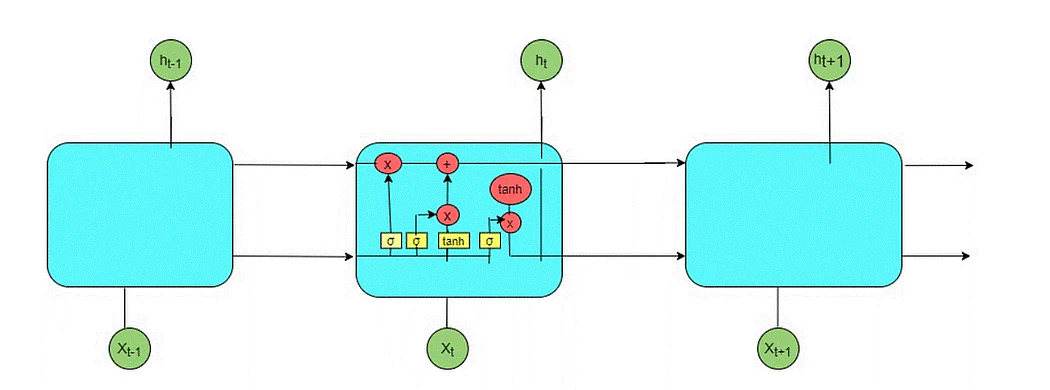

Informasi yang dikumpulkan oleh algoritma LSTM kemudian akan disimpan oleh cell dan manipulasi memori dilakukan oleh komponen yang disebut dengan gate. Ada tiga jenis gate pada algoritma LSTM, di antaranya  Forget gate, Input gate, dan  Output gate. Sumber : [Trivusi](https://www.trivusi.web.id/2022/07/algoritma-lstm.html)

Jaringan syaraf dalam kasus chatbot ini yang terdiri dari lapisan atau *layer* embedding yang merupakan salah satu hal yang paling kuat di bidang pemrosesan bahasa alami atau NLP. output atau keluaran dari lapisan (*layer*) embedding adalah input (masukan) data teks dari lapisan berulang (*recurrent*) dengan layer LSTM gate (Lapisan Gerbang **Long Shot Term Memory)**. Kemudian, output atau keluaran diratakan dan lapisan Dense digunakan dengan fungsi aktivasi **Softmax** yang dimana implementasi chatbot ini memiliki data label lebih dari dua kelas.

Bagian utama dalam pemodelan chatbot ini adalah lapisan embedding yang memberikan nilai vektor yang sesuai untuk setiap kata dalam data teks yang telah dimasukkan.

In [ ]:
# Creating the model (Membuat Modelling)
i = Input(shape=(input_shape,)) # Layer Input
x = Embedding(vocabulary+1,10)(i) # Layer Embedding
x = LSTM(10, return_sequences=True, recurrent_dropout=0.2)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model  = Model(i,x) # Model yang telah disusun dari layer Input sampai layer Output

# Compiling the model (Kompilasi Model)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [ ]:
# Menampilkan parameter pada model LSTM
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 embedding (Embedding)       (None, 6, 10)             1140      
                                                                 
 lstm (LSTM)                 (None, 6, 10)             840       
                                                                 
 flatten (Flatten)           (None, 60)                0         
                                                                 
 dense (Dense)               (None, 17)                1037      
                                                                 
Total params: 3017 (11.79 KB)
Trainable params: 3017 (11.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Training the model (Melatih model data sampai 450 kali)
train = model.fit(x_train, y_train, epochs=450)

Epoch 1/450
3/3 [==============================] - 3s 15ms/step - loss: 2.8328 - accuracy: 0.0488
Epoch 2/450
3/3 [==============================] - 0s 13ms/step - loss: 2.8282 - accuracy: 0.0732
Epoch 3/450
3/3 [==============================] - 0s 17ms/step - loss: 2.8240 - accuracy: 0.2195
Epoch 4/450
3/3 [==============================] - 0s 13ms/step - loss: 2.8198 - accuracy: 0.2195
Epoch 5/450
3/3 [==============================] - 0s 12ms/step - loss: 2.8154 - accuracy: 0.2073
Epoch 6/450
3/3 [==============================] - 0s 12ms/step - loss: 2.8099 - accuracy: 0.2073
Epoch 7/450
3/3 [==============================] - 0s 11ms/step - loss: 2.8055 - accuracy: 0.2073
Epoch 8/450
3/3 [==============================] - 0s 12ms/step - loss: 2.7994 - accuracy: 0.2073
Epoch 9/450
3/3 [==============================] - 0s 12ms/step - loss: 2.7928 - accuracy: 0.2073
Epoch 10/450
3/3 [==============================] - 0s 12ms/step - loss: 2.7858 - accuracy: 0.2073
Epoch 11/450
3/3 [=

# **Evaluation Model Analysis**

Setelah menjalankan pelatihan model dengan algoritma LSTM serta telah mengetahui hasil akurasi pada step terakhir. Maka, tahapan selanjutnya adalah menganalisa model dengan visualisasi plot akurasi dan loss untuk melihat hasil akurasi dari algoritma pelatihan model LSTM tersebut.

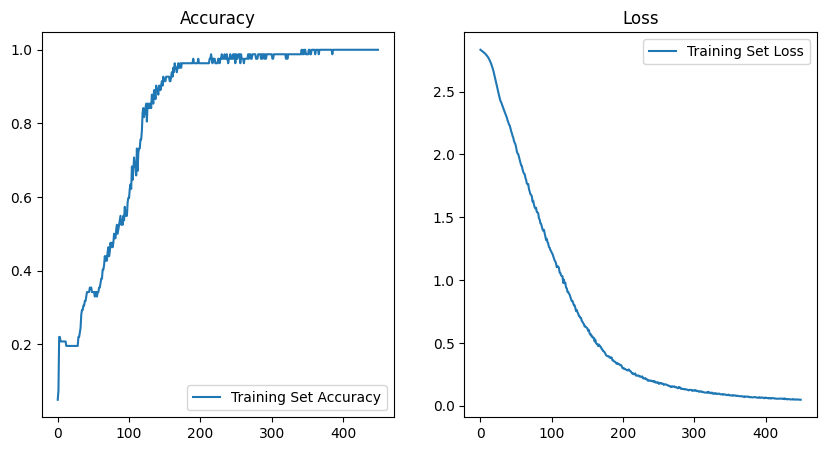

In [ ]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'], label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'], label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

Terlihat bahwa model pelatihan chatbot dengan algoritma LSTM menghasilkan model yang baik dan tidak terjadi overfitting atau underfitting. Sehingga, model ini layak dilakukan pengujian dan evaluasi model chatbot yang diperoleh.

# **Testing Chatbot**

Setelah mengetahui hasil dari akurasi dan loss pada model yang telah ditetapkan dengan LSTM. Maka, tahapan selanjutnya adalah menguji atau testing pada chatbot yang telah dilatih sebelumnya dan melihat apakah sesuai atau tidak pada saat kita masukan teks kalimat pertanyaannya.

Pada pengujian ini menggunakan metode input atau masukan sesuai dengan kalimat pertanyaan yang dimasukkan.

In [ ]:
# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('👨‍🦰 user : ')

  # Menghapus punktuasi atau tanda baca dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Melakukan Tokenisasi dan Padding pada data teks
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  # Konversi data teks menjadi array
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  # Mendapatkan hasil prediksi keluaran pada model
  output = model.predict(prediction_input)
  output = output.argmax()

  # Menemukan respon sesuai data tag dan memainkan suara bot
  response_tag = le.inverse_transform([output])[0]
  # Bot akan melakukan random jawaban percakapan dari hasil pertanyaan
  print("🤖 ScoutBot : ", random.choice(responses[response_tag]))
  # Tambahkan suara bot dengan Google Text to Speech
  tts = gTTS(random.choice(responses[response_tag]), lang='id')
  # Simpan model voice bot ke dalam Google Drive dengan format .wav
  tts.save('ScoutBot.wav')
  # Atur waktu jeda sampai 8 detik
  time.sleep(0.08)
  # Ambil file model yang telah disimpan sebelumnya
  ipd.display(ipd.Audio('/content/ScoutBot.wav', autoplay=False))
  print("="*60 + "\n")


👨‍🦰 user : samlekom
1/1 [==============================] - 0s 26ms/step
🤖 ScoutBot :  Waalaikumsalam wr wb, ini ScoutBot, ScoutBot bakal bantu kamu tentang informasi UKK Pramuka UIN SGD😉



👨‍🦰 user : halo
1/1 [==============================] - 0s 23ms/step
🤖 ScoutBot :  Hai Hai! Aku ScoutBot, Kaliatannya lagi mau daftar UKK Pramuka UIN SGD yaa?



👨‍🦰 user : iya  ni! apa saja persyaratan untuk menjadi anggota ukk pramuka?
1/1 [==============================] - 0s 38ms/step
🤖 ScoutBot :  persyaratan untuk menjadi anggota pramuka UIN SGD Bandung adalah sebagai berikut. 
 Persyaratan umum:
 1. mahasiswa aktif UIN SGD Bandung/mahasiswa umum
 2. Mengisi formulir pendaftaran secara online
 3. Melampirkan foto berseragam Pramuka ukuran 3x4 (warna background sesuai dengan golongan kepramukaan)

 persyaratan tambahan:
 Bagi calon pendaftaran jalur prestasi wajib melampirkan bukti kelulusan penerimaan mahasiswa baru UIN Bandung jalur prestasi pramuka


KeyboardInterrupt: ignored

# **Save The Model (Simpan Model)**

Setelah pengujian Chatbot telah disesuaikan dengan kalimat dan jawabannya. Maka, model chatbot bisa disimpan dengan format .h5 atau .pkl (pickle) untuk penggunaan aplikasi AI Chatbot dengan website atau sistem Android. Penyimpanan file model bisa langsung secara transient file lokal komputer atau bisa taruh dalam cloud storage di Google Drive.

In [ ]:
# Simpan model dalam bentuk format file .h5 atau .pkl (pickle)
model.save('chat_model.h5')

print('Model Created Successfully!')